In [1]:
!conda install -yc conda-forge geocoder lxml cssselect geopy

import pandas as pd
import numpy as np
import geocoder 
import folium # map rendering library
import requests
from geopy.geocoders import Nominatim
import time
import math
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - cssselect
    - geocoder
    - geopy
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    libblas-3.8.0              |      11_openblas          10 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6         

## Define function for getting coordinates of searched entity

In [2]:
geolocator = Nominatim(user_agent="ra_ex")
def get_location(address):
    print(address, end = ' => ')
    attempts = 5
    location = None
    for attempt in range(attempts):
        time.sleep(1)
        try:
            location = geolocator.geocode(address)
            break
        except:
            print(attempt, end = '')
    #print('.', end = '')
    if location:
        print(location)
        return pd.Series((location.latitude, location.longitude), index = ('Latitude', 'Longitude'))
    else:
        print(" X")
        return pd.Series((0, 0), index = ('Latitude', 'Longitude'))

## Define function for determining whether object is in the cluster
*Identifies whether object (employer or venue) is in the cluster.<br>
Object's and cluster's coordinates are in grads, cluster's radius is in meters<br>
Coordinates are passed as a list where first value is latitude and second is longitude*

In [3]:
def is_in_cluster(object_coords, cluster_coords, cluster_radius = 600):
    R = 6371009 # Earth radius in meters
    d_fi = (object_coords[0] - cluster_coords[0]) * math.pi / 180
    fi_m = (object_coords[0] + cluster_coords[0]) * math.pi / 180 / 2
    d_lambda = (object_coords[1] - cluster_coords[1]) * math.pi / 180
    D = R * math.sqrt(d_fi ** 2 + (math.cos(fi_m) * d_lambda) ** 2)
    return D < cluster_radius
def find_object_cluster(object_coords, clusters):
    for cluster in clusters:
        if is_in_cluster(object_coords, cluster[1:3]):
            return cluster[0]
    return ''

## Define Foursquare Credentials and Version

In [4]:
CLIENT_ID = 'IHA2RZ534UBEJJ0OX0X3HCPDS4HQL4TQTCUHCYPEW3XLQDO3' # your Foursquare ID
CLIENT_SECRET = 'LASEJ4FGP0SZSRYNE4I3YE2MCWI2YWAIAAPSUX54EPELLAFD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IHA2RZ534UBEJJ0OX0X3HCPDS4HQL4TQTCUHCYPEW3XLQDO3
CLIENT_SECRET:LASEJ4FGP0SZSRYNE4I3YE2MCWI2YWAIAAPSUX54EPELLAFD


In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
def getNearbyVenues(names, latitudes, longitudes, categories = [], radius=1000, limit = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('{}... '.format(name), end = '')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            ','.join(categories)
        )
            
        # make the GET request
        response = requests.get(url).json()
        #print(response)
        results = response["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print("found {} venues.".format(len(results)))

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Cluster', 
                  'Cluster Latitude', 
                  'Cluster Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Getting fast food categories**

In [7]:
fastfoodCategories = [['4bf58dd8d48988d1df931735', 'BBQ Joint'], ['4bf58dd8d48988d179941735', 'Bagel Shop'], ['52e81612bcbc57f1066b79f1', 'Bistro'], 
                      ['4bf58dd8d48988d143941735', 'Breakfast Spot'], ['4bf58dd8d48988d16c941735', 'Burger Joint'], ['4bf58dd8d48988d153941735', 'Burrito Place'], 
                      ['56aa371ce4b08b9a8d57358b', 'Currywurst Joint'], ['4bf58dd8d48988d147941735', 'Diner'], ['4bf58dd8d48988d148941735', 'Donut Shop'], 
                      ['4bf58dd8d48988d16e941735', 'Fast Food Restaurant'], ['4bf58dd8d48988d120951735', 'Food Court'], ['5283c7b4e4b094cb91ec88d7', 'Kebab Restaurant'], 
                      ['4bf58dd8d48988d1ca941735', 'Pizza Place'], ['4bf58dd8d48988d1bd941735', 'Salad Place'], ['4bf58dd8d48988d1c5941735', 'Sandwich Place'], 
                      ['5bae9231bedf3950379f89e4', 'Shawarma Place'], ['4bf58dd8d48988d1c7941735', 'Snack Place'], ['4bf58dd8d48988d1dd931735', 'Soup Place'], 
                      ['53e0feef498e5aac066fd8a9', 'Street Food Gathering'], ['55a5a1ebe4b013909087cb7f', 'Trattoria/Osteria']]

## Explore Berlin employers

*Define clusters for largest companies*<br>
Cluster are defined first using KMeans clustering and elbow method to identify optimal number of clusters. 

In [8]:
df_berlin_jobs = pd.read_csv('berlin-jobs.csv')
df_berlin_jobs = df_berlin_jobs[df_berlin_jobs['Latitude'] != 0]

In [39]:
df_berlin_jobs.shape

(72, 5)

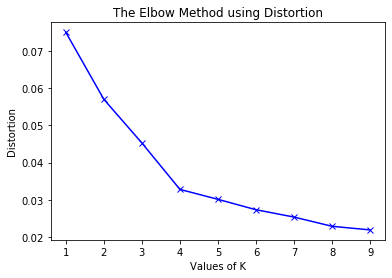

In [43]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
X = df_berlin_jobs[['Latitude', 'Longitude']]
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [44]:
kModel = KMeans(n_clusters=4).fit(X)
#Visualizing the data 
colors = ['blue', 'orange', 'red', 'purple']
X['Cluster'] = [colors[c] for c in kModel.labels_]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
address = 'Berlin, Germany'

loc_berlin = get_location(address)
print('The geograpical coordinate of Berlin are {}, {}.'.format(loc_berlin['Latitude'], loc_berlin['Longitude']))

Berlin, Germany => Berlin, 10117, Deutschland
The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


#### Let's put all companies to the Berlin map and highlight the clusters

In [46]:
# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[loc_berlin['Latitude'], loc_berlin['Longitude']], zoom_start=11)

# add markers to map
for lat, lng, cluster in zip(df_berlin_jobs['Latitude'], X['Longitude'], X['Cluster']):
    folium.CircleMarker(
        [lat, lng],
        radius = 5, 
        color = cluster,
        fill = True,
        fill_color = cluster,
        fill_opacity = 0.7,
        parse_html = False).add_to(map_berlin)  
 
map_berlin

*Then due to unsatisfactory result of clustering it's done visually by looking for groups of companies taking into consideration amount of markers and their size (marker size is defined by open positions count)*

In [28]:
berlin_clusters = [
    ["Cluster 1", 52.526, 13.342],
    ["Cluster 2", 52.524, 13.40755],
    ["Cluster 3", 52.533, 13.383],
    ["Cluster 4", 52.519, 13.389],
    ["Cluster 5", 52.543, 13.416],
    ["Cluster 6", 52.503, 13.341],
    ["Cluster 7", 52.5005, 13.373]
]

In [29]:
# Defining clusters is a visual process and performed when all employers are placed on the map below. 
# This line of assigning cluster to each employer is added later when clusters are defined
df_berlin_jobs = df_berlin_jobs.join(df_berlin_jobs.apply(lambda emp: find_object_cluster(emp[2:4], berlin_clusters), axis = 1).rename('Cluster'))
print(df_berlin_jobs.shape)

(72, 5)


In [31]:
# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[loc_berlin['Latitude'], loc_berlin['Longitude']], zoom_start=13)

# add cluster markers to the map
for id, lat, lng in berlin_clusters:
    label = folium.Popup(str(id), parse_html = True)
    folium.Circle(
        [lat, lng],
        popup = label,
        radius = 600,
        color = 'red',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.5,
        parse_html = False).add_to(map_berlin) 

# add markers to map
for lat, lng, company, positions, cluster in zip(df_berlin_jobs['Latitude'], df_berlin_jobs['Longitude'], df_berlin_jobs['Company'], df_berlin_jobs['Positions'], df_berlin_jobs['Cluster']):
    label = "{}, {} positions\n{},{}\nCluster: {}".format(company, positions, lat, lng, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        # marker size is defined by amount of open positions. 
        # In order to keep sizes in some reasonable boundaries square root is taken
        radius = math.sqrt(positions), 
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_berlin)  
 
map_berlin

## Getting venues for each Berlin cluster defined
**In order to save API calls to Foursquare I call it once and save results to the CSV file. Then I reuse data from CSV**

In [29]:
#tmp = pd.DataFrame(berlin_clusters)
#berlin_venues = getNearbyVenues(names=tmp[0],
#                                latitudes=tmp[1],
#                                longitudes=tmp[2],
#                                categories = np.transpose(fastfoodCategories)[0],
#                                radius = 600
#                               )
#berlin_venues.to_csv('berlin-venues.csv', index = False)

Cluster 1... found 25 venues.
Cluster 2... found 87 venues.
Cluster 3... found 17 venues.
Cluster 4... found 45 venues.
Cluster 5... found 56 venues.
Cluster 6... found 50 venues.
Cluster 7... found 7 venues.


In [26]:
berlin_venues = pd.read_csv('berlin-venues.csv')
berlin_venues_by_cluster = berlin_venues.pivot_table(index = 'Venue Category', columns = 'Cluster', values = 'Venue', aggfunc = 'count', fill_value = 0, margins = True, margins_name = 'Total')
berlin_venues_by_cluster

Cluster,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Total
Venue Category,,,,,,,,
Asian Restaurant,0,1,0,0,0,0,0,1
BBQ Joint,1,3,0,0,1,2,0,7
Bagel Shop,1,3,2,0,0,0,0,6
Bar,0,1,0,0,0,0,0,1
Bistro,5,11,4,3,2,6,1,32
Breakfast Spot,3,12,6,8,15,5,2,51
Brewery,0,0,0,0,0,0,1,1
Burger Joint,5,11,1,1,8,4,0,30
Burrito Place,0,4,0,1,1,2,0,8


## Getting fastfood saturation index

In [82]:
# First we get size of each cluster in regards to jobs available, which leads to size of companies located in the cluster
berlin_clusters_size = df_berlin_jobs.groupby('Cluster').sum().drop('')['Positions'].rename('Employers size')
# Then we get amount of venues in the cluster
berlin_venues_by_cluster_total = berlin_venues_by_cluster.loc['Total'].drop('Total').rename('Fastfood venues')
# And finally we calculate saturation index for each cluster (the larger number the higher fastfoods saturation)
berlin_venues_saturation = pd.DataFrame(berlin_clusters_size).join(berlin_venues_by_cluster_total).join((berlin_venues_by_cluster_total / berlin_clusters_size).rename('Saturation'))
berlin_venues_saturation

,Employers size,Fastfood venues,Saturation
Cluster,,,
Cluster 1,56,25,0.446429
Cluster 2,22,87,3.954545
Cluster 3,82,17,0.207317
Cluster 4,11,45,4.090909
Cluster 5,32,56,1.750000
Cluster 6,9,50,5.555556
Cluster 7,16,7,0.437500


### And absolutely last thing - we calculate average saturation index for Berlin

In [83]:
berlin_fastfood_venues_saturation_index = berlin_venues_saturation['Saturation'].mean()
berlin_fastfood_venues_saturation_index

2.3488936779442002

## Explore Brno employers

In [32]:
brno_clusters = [
    ["Cluster 1", 49.226, 16.577966],
    ["Cluster 2", 49.189, 16.616973],
    ["Cluster 3", 49.175497, 16.566303],
    ["Cluster 4", 49.181953, 16.6060658], 
    ['Cluster 5', 49.15525, 16.603149], 
    ['Cluster 6', 49.17592, 16.67]
]

In [33]:
address = 'Brno, Czech Republic'

loc_brno = get_location(address)
print('The geograpical coordinate of Brno are {}, {}.'.format(loc_brno['Latitude'], loc_brno['Longitude']))

Brno, Czech Republic => Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česká republika
The geograpical coordinate of Brno are 49.1922443, 16.6113382.


In [34]:
df_brno_jobs = pd.read_csv('brno-jobs.csv')
df_brno_jobs = df_brno_jobs[df_brno_jobs['Latitude'] != 0]
# Defining clusters is a visual process and performed when all employers are placed on the map below. 
# This line of assigning cluster to each employer is added later when clusters are defined
df_brno_jobs = df_brno_jobs.join(df_brno_jobs.apply(lambda emp: find_object_cluster(emp[2:4], brno_clusters), axis = 1).rename('Cluster'))
df_brno_jobs.head()

,Company,Positions,Latitude,Longitude,Cluster
0,ABB,33,49.155259,16.603149,Cluster 5
1,AT&T,19,49.175497,16.566303,Cluster 3
3,Air Products,1,49.172436,16.677561,
4,Atlas Copco,1,49.177055,16.675764,Cluster 6
5,Bayer,1,49.224079,16.583736,Cluster 1


In [37]:
# create map of Brno using latitude and longitude values
map_brno = folium.Map(location=[loc_brno['Latitude'], loc_brno['Longitude']], zoom_start=13)

# add cluster markers to the map
for id, lat, lng in brno_clusters:
    label = folium.Popup(str(id), parse_html = True)
    folium.Circle(
        [lat, lng],
        popup = label,
        radius = 500,
        color = 'red',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.5,
        parse_html = False).add_to(map_brno) 

# add markers to map
for lat, lng, company, positions, cluster in zip(df_brno_jobs['Latitude'], df_brno_jobs['Longitude'], df_brno_jobs['Company'], df_brno_jobs['Positions'], df_brno_jobs['Cluster']):
    label = "{}, {} positions\n{},{}\nCluster: {}".format(company, positions, lat, lng, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        # marker size is defined by amount of open positions. 
        # In order to keep sizes in some reasonable boundaries square root is taken
        radius = math.sqrt(positions), 
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_brno)  
 
map_brno

## Getting venues for each Brno cluster defined
**Same as for Berlin I get venues from Foursquare once and save data to CSV, which I then reuse**

In [123]:
#tmp = pd.DataFrame(brno_clusters)
#brno_venues = getNearbyVenues(names=tmp[0],
#                                latitudes=tmp[1],
#                                longitudes=tmp[2],
#                                categories = np.transpose(fastfoodCategories)[0],
#                                radius = 500
#                               )
#brno_venues.to_csv('brno-venues.csv', index = False)

Cluster 1... found 4 venues.
Cluster 2... found 34 venues.
Cluster 3... found 11 venues.
Cluster 4... found 5 venues.
Cluster 5... found 4 venues.
Cluster 6... found 0 venues.


In [124]:
brno_venues = pd.read_csv('brno-venues.csv')
brno_venues_by_cluster = brno_venues.pivot_table(index = 'Venue Category', columns = 'Cluster', values = 'Venue', aggfunc = 'count', fill_value = 0, margins = True, margins_name = 'Total')
brno_venues_by_cluster

Cluster,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Total
Venue Category,,,,,,
Bistro,0,4,2,3,0,9
Breakfast Spot,0,1,0,0,0,1
Burger Joint,1,2,0,0,1,4
College Cafeteria,1,0,0,0,0,1
Donut Shop,0,1,0,0,0,1
Fast Food Restaurant,2,15,4,1,2,24
Food & Drink Shop,0,1,0,0,0,1
Food Court,0,1,1,0,0,2
Organic Grocery,0,0,1,0,0,1


## Getting fastfood saturation index

In [126]:
# First we get size of each cluster in regards to jobs available, which leads to size of companies located in the cluster
brno_clusters_size = df_brno_jobs.groupby('Cluster').sum().drop('')['Positions'].rename('Employers size')
# Then we get amount of venues in the cluster
brno_venues_by_cluster_total = brno_venues_by_cluster.loc['Total'].drop('Total').rename('Fastfood venues')
# And finally we calculate saturation index for each cluster (the larger number the higher fastfoods saturation)
brno_venues_saturation = pd.DataFrame(brno_clusters_size).join(brno_venues_by_cluster_total).join((brno_venues_by_cluster_total / brno_clusters_size).rename('Saturation'))
# Because some clusters have no fastfood venues at all we fill NaNs with zeros
brno_venues_saturation = brno_venues_saturation.fillna(0)
brno_venues_saturation

,Employers size,Fastfood venues,Saturation
Cluster,,,
Cluster 1,130,4.0,0.030769
Cluster 2,67,34.0,0.507463
Cluster 3,40,11.0,0.275000
Cluster 4,35,5.0,0.142857
Cluster 5,33,4.0,0.121212
Cluster 6,27,0.0,0.000000


### And now let's see the deviation from reference average saturation index

In [133]:
brno_venues_saturation.join((berlin_fastfood_venues_saturation_index - brno_venues_saturation['Saturation']).rename('Saturation deviation')).sort_values('Saturation deviation', ascending = False)

,Employers size,Fastfood venues,Saturation,Saturation deviation
Cluster,,,,
Cluster 6,27,0.0,0.000000,2.348894
Cluster 1,130,4.0,0.030769,2.318124
Cluster 5,33,4.0,0.121212,2.227682
Cluster 4,35,5.0,0.142857,2.206037
Cluster 3,40,11.0,0.275000,2.073894
Cluster 2,67,34.0,0.507463,1.841431


### Conclusion: 
The most perspective cluster to build new fastfood venues would be Cluster 6 as it has lowest saturation index of ones. <br/>
However the Cluster 6 looks pretty empty and its value is mostly formed by one company. <br/>
Therefore Cluster 1 looks more attractive as its saturation index is nearly same but it has more companies located and this implies further development of that area.